# Comparison of Distance Measures and Prototype Selection Strategies on UCR datasets

As a part of this thesis, we tested multiple combinations of different distance measures and Feature DTW transformations, including various strategies for prototype selection on UCR datasets. In our implementation, we are using five-split cross-validation and comparing the average accuracy of each algorithm. For complete results, please see our repository.

Based on our results, we make these conclusions:
* The overall best distance measure is a combination of constrained DTW computed on the original time series and their derivations.
* Prototyped Feature DTW outperforms Prototyped Feature DTW.
* Random selection of prototypes can be a useful starting strategy.


### Notation
Distance measures:
* *dtw* - Dynamic Time Warping
* *fdtw* - Fast Dynamic Time Warping
* *sakoe_chiba* - DTW with Sakoe-Chiba constraint
* *itakura* - DTW with Itakura constraint
* *dd_distance_measure_a* - a combination of distance measure using the original time series and their first derivatives ( (1 - a) * dist(x, y) + a * dist(x', y')

Prototype selections + classification methods:
* *Random_X* - randomly selecting *X%* of training data as prototypes (Random_10, Random_30, Random_50) + Linear SVC
* *LassoSVC* - selecting prototypes with the highest importance from the Linear Support Vector Machine classifier with l1 penalization + Linear SVC
* *Tree* - selecting prototypes with the highest importance from the Extra Tree Classifier + Linear SVC
* *SVC* - all prototypes + Linear SVC
* *1NN* - Nearest Neighbor classifier using one closest neighbor

In [1]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.cm import tab20

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

plt.style.use("seaborn-notebook")

In [3]:
from itertools import combinations

In [4]:
from scipy.stats import wilcoxon
from sklearn.metrics import pairwise_distances

In [5]:
RESULTS_PATH = Path("../../results/")

In [18]:
results = pd.concat(
    [
        pd.read_csv(
            RESULTS_PATH / "classification_feature_dtw.csv",
            header=None,
            names=["dataset", "metric", "method", "accuracy"],
        ),
        pd.read_csv(
            RESULTS_PATH / "classification_feature_dd_dtw.csv",
            header=None,
            names=["dataset", "metric", "method", "accuracy"],
        ),
        pd.read_csv(
            RESULTS_PATH / "classification_select_features_fdtw.csv",
            header=None,
            names=["dataset", "metric", "method", "accuracy", "n_features"],
        ),
    ]
)

In [7]:
# Renaming names from classification logs
results["method"] = results["method"].replace(
    {
        "GradientBoostingClassifier": "GBC",
        "KNeighborsClassifier": "1NN",
        "LinearSVC": "SVC",
    }
)

In [8]:
dataset_table = results.pivot(
    index="dataset", columns=["metric", "method"], values="accuracy"
)

dataset_table = dataset_table[~dataset_table.isna().any(axis=1)]

In [9]:
dataset_table.shape

(44, 72)

In [10]:
mean_rank = dataset_table.rank(ascending=False, axis=1).T.mean(axis=1).sort_values(0)
mean_rank.reset_index()

,metric,method,0
0,dd_itakura_0.6,LassoSVC,23.761364
1,dd_fdtw_0.8,LassoSVC,25.193182
2,dd_itakura_0.6,SVC,25.352273
3,dd_fdtw_0.6,LassoSVC,25.625000
4,dd_sakoe_chiba_0.6,SVC,25.761364
...,...,...,...
67,dd_itakura_0.6,Random_10,49.272727
68,dd_dtw_0.8,Random_10,52.181818
69,dd_itakura_0.8,Random_10,52.420455
70,dd_fdtw_0.8,Random_10,54.670455


In [11]:
mean_acc = dataset_table.T.mean(axis=1).sort_values(0, ascending=False)
mean_acc.reset_index()

,metric,method,0
0,dd_fdtw_0.8,LassoSVC,0.882611
1,dd_fdtw_0.8,SVC,0.881105
2,dd_fdtw_0.6,LassoSVC,0.880506
3,dd_fdtw_0.6,SVC,0.877067
4,dd_itakura_0.6,SVC,0.873755
...,...,...,...
67,dd_sakoe_chiba_0.8,Random_10,0.799839
68,dd_fdtw_0.6,Random_10,0.798474
69,dd_fdtw_0.8,Random_10,0.797000
70,dd_itakura_0.8,Random_10,0.793562


In [12]:
dataset_table.T.median(axis=1).sort_values(0, ascending=False).reset_index()

,metric,method,0
0,dd_fdtw_0.6,SVC,0.935940
1,dd_fdtw_0.4,SVC,0.927110
2,dd_fdtw_0.6,LassoSVC,0.926515
3,fdtw,SVC,0.921020
4,dd_dtw_0.8,SVC,0.918065
...,...,...,...
67,dd_itakura_0.6,Random_10,0.824390
68,dd_sakoe_chiba_0.8,Random_10,0.819485
69,dd_dtw_0.8,Random_10,0.818655
70,dd_fdtw_0.8,Random_10,0.818300


In [13]:
std_index = dataset_table.std(axis=1).sort_values(ascending=True).index.values

<ipython-input-21-73d9b782630c>:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  mx.loc[x].plot(


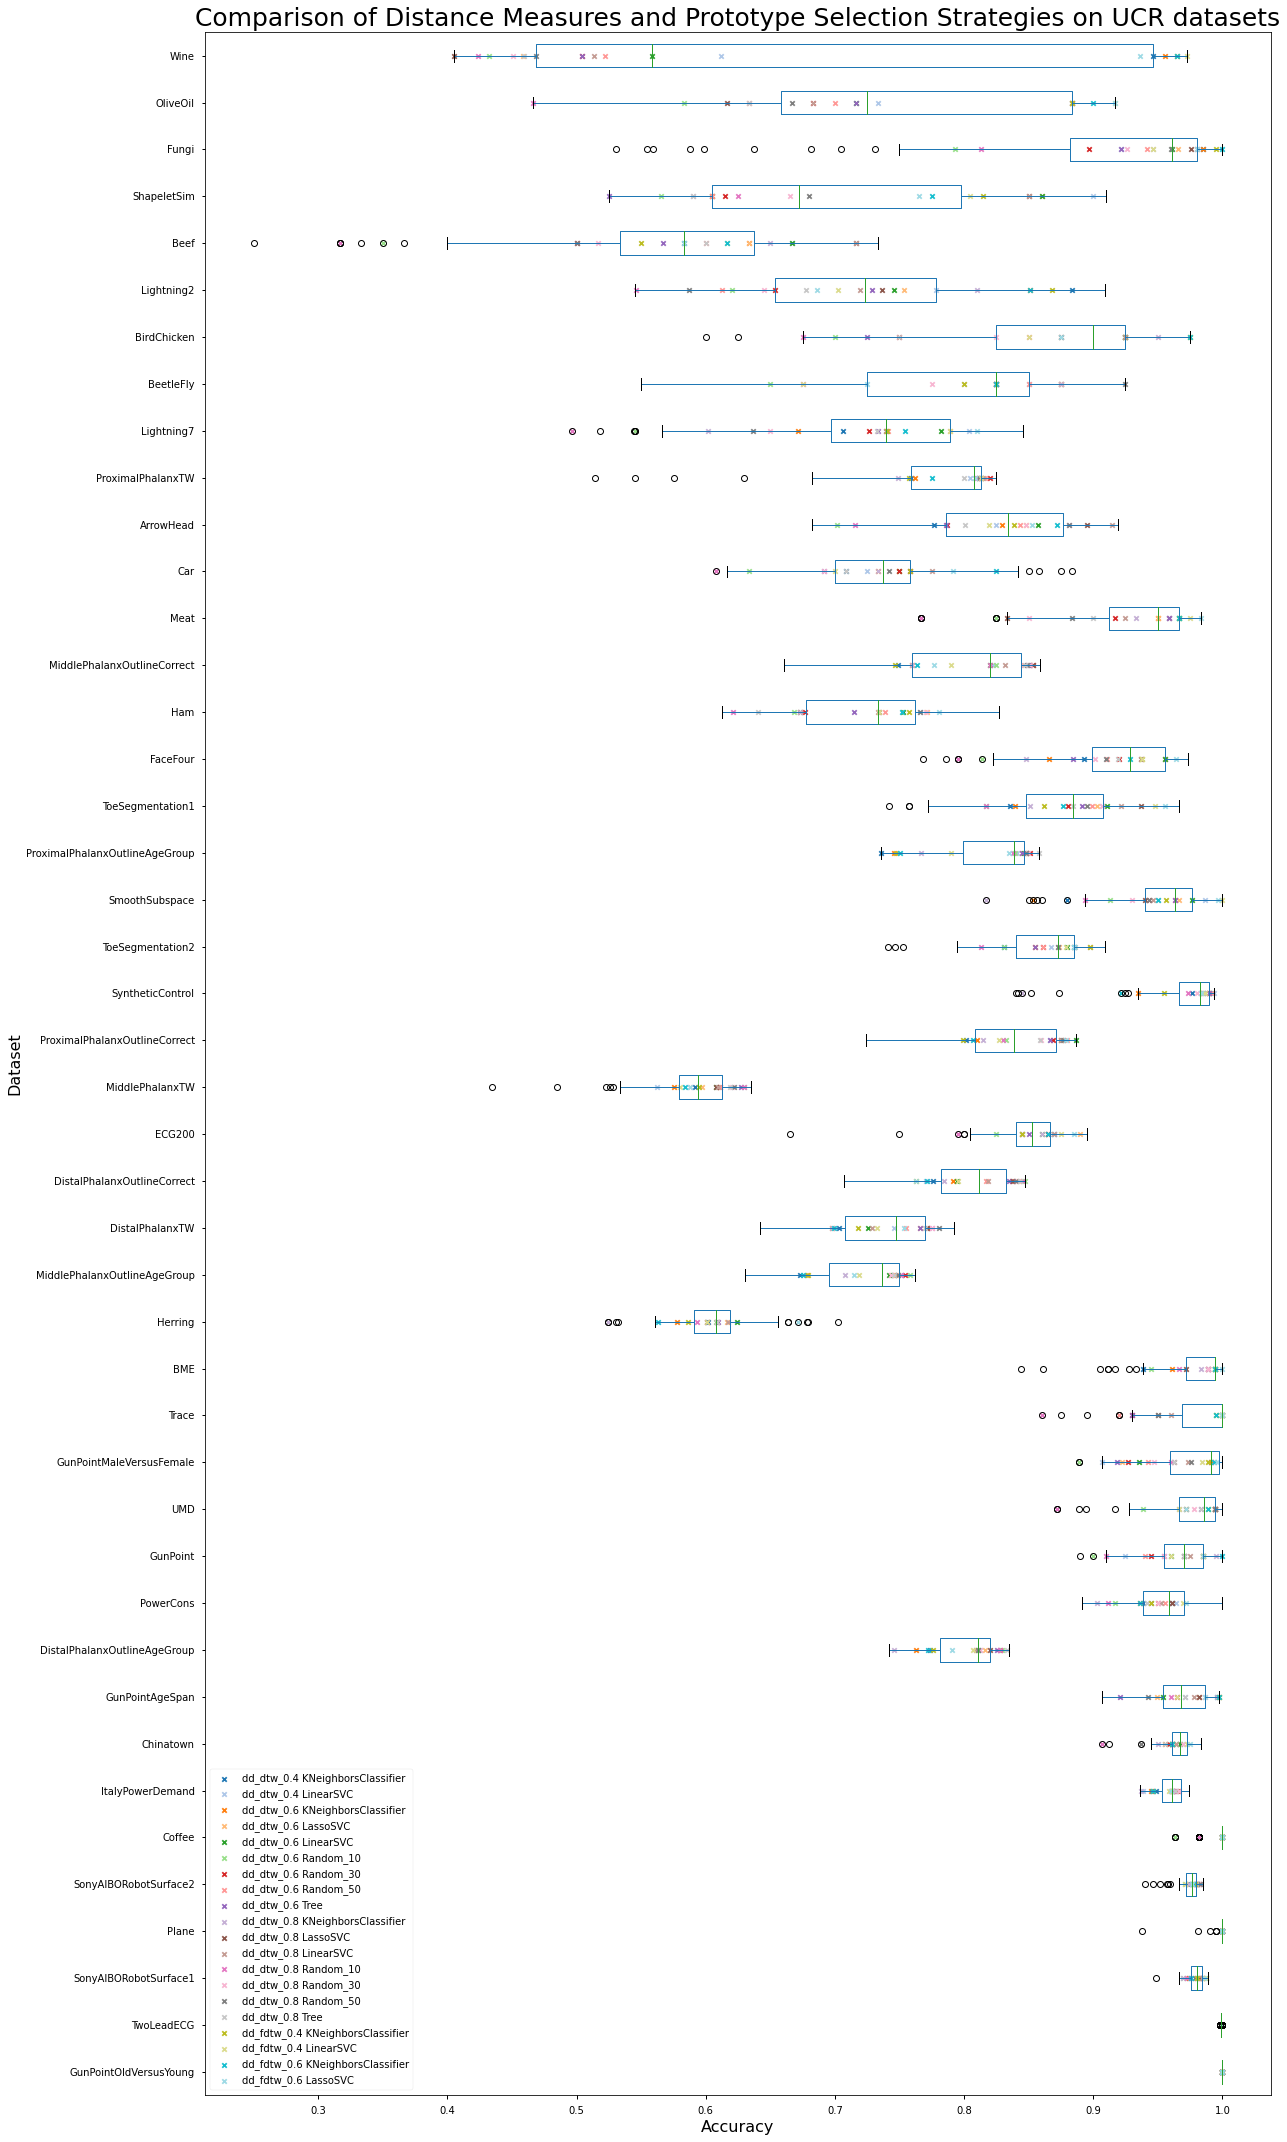

In [21]:
figure = plt.figure(figsize=(18, 30))
ax = plt.gca()

dataset_table.loc[std_index].T.boxplot(vert=False, ax=ax)

mx = results[np.isin(results.dataset, std_index)].set_index(["metric", "method"])
mx.dataset = mx.dataset.replace({x: i for i, x in enumerate(std_index, 1)})

for x, color in zip(np.unique(mx.index.values), tab20.colors):
    mx.loc[x].plot(
        kind="scatter",
        x="accuracy",
        y="dataset",
        marker="x",
        label=" ".join(x),
        color=color,
        ax=ax,
    )


plt.legend()
plt.title(
    "Comparison of Distance Measures and Prototype Selection Strategies on UCR datasets",
    fontsize=25,
)
plt.ylabel("Dataset", fontsize=16)
plt.xlabel("Accuracy", fontsize=16)

plt.savefig("../../thesis/img/ucr_accuracy.png")
plt.tight_layout()

plt.show()

No handles with labels found to put in legend.


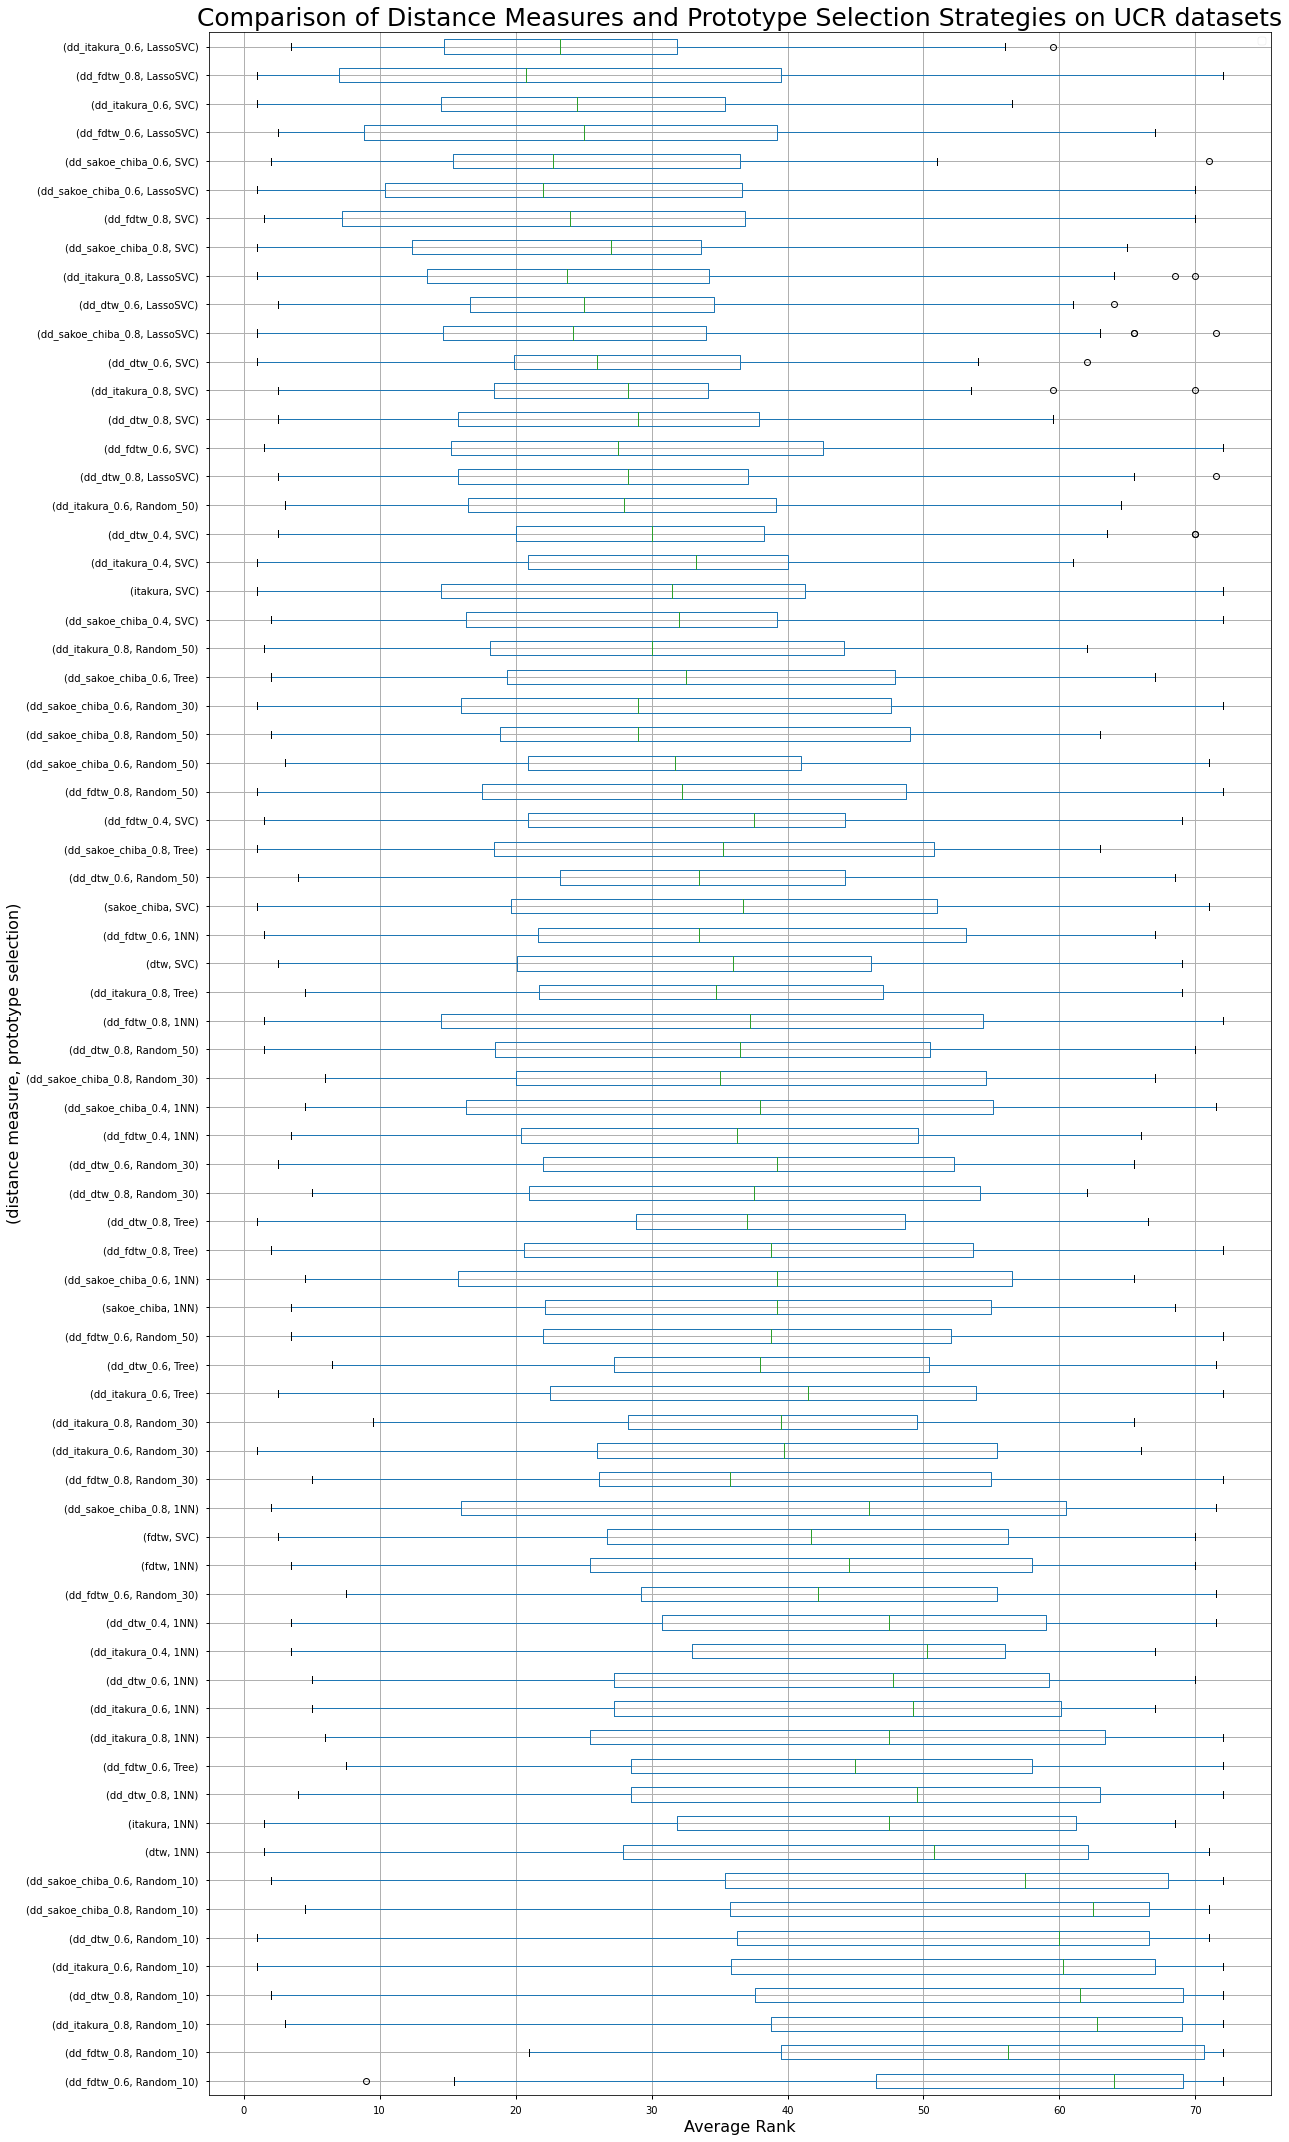

In [22]:
figure = plt.figure(figsize=(18, 30))
ax = plt.gca()


dataset_table.rank(ascending=False, axis=1).loc[:, mean_rank.index[::-1]].boxplot(
    vert=False, ax=ax
)


plt.legend()
plt.title(
    "Comparison of Distance Measures and Prototype Selection Strategies on UCR datasets",
    fontsize=25,
)
plt.ylabel("(distance measure, prototype selection)", fontsize=16)
plt.xlabel("Average Rank", fontsize=16)

plt.savefig("../../thesis/img/ucr_avg_rank.png")
plt.tight_layout()

plt.show()